In [ ]:
# Install dependencies (run once)
!pip install flask flask-cors pyngrok

# Copy the code from scripts/germination-net-server.py
# Replace YOUR_NGROK_TOKEN_HERE with your actual token
# Replace MODEL_PATH with your model file location on Google Drive



# Run this in your Google Colab notebook to expose your GerminationNet model
# This creates a Flask API that your dashboard can connect to

# 1. Install dependencies
# !pip install flask flask-cors pyngrok requests pillow

import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import requests
from io import BytesIO
from flask import Flask, request, jsonify
from flask_cors import CORS
from pyngrok import ngrok

# Load your trained GerminationNet model
class GerminationNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet18(weights=None)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.backbone(x).squeeze(1)

# Initialize
device = "cuda" if torch.cuda.is_available() else "cpu"
model = GerminationNet().to(device)

# Load your trained weights
MODEL_PATH = "/content/drive/MyDrive/germination_project/germination_resnet18.pth"
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Flask app
app = Flask(__name__)
CORS(app)

@app.route('/health', methods=['GET'])
def health():
    return jsonify({"status": "healthy", "model": "GerminationNet", "device": device})

@app.route('/predict', methods=['POST'])
def predict():
    try:
        data = request.json
        image_url = data.get('image_url')

        if not image_url:
            return jsonify({"error": "image_url required"}), 400

        # Download image
        response = requests.get(image_url, timeout=10)
        img = Image.open(BytesIO(response.content)).convert('RGB')

        # Preprocess and predict
        x = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            logit = model(x)
            probability = torch.sigmoid(logit).item()

        return jsonify({
            "probability": probability,
            "is_germinated": probability >= 0.5,
            "confidence": probability,
            "model": "GerminationNet-ResNet18"
        })

    except Exception as e:
        return jsonify({"error": str(e)}), 500

# Start ngrok tunnel
# Set your ngrok token first: ngrok.set_auth_token("YOUR_TOKEN")
ngrok.set_auth_token("XXXXXXXXXXXXX")
public_url = ngrok.connect(5000)
print(f"\n🚀 GerminationNet API is running!")
print(f"📡 Public URL: {public_url}")
print(f"🔗 Use this endpoint: {public_url}/predict\n")

# Run Flask
app.run(port=5000)



ERROR:pyngrok.process.ngrok:t=2025-12-08T19:33:46+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: The authtoken you specified does not look like a proper ngrok authtoken.\nYour authtoken: Y36ZkF1zcM5ijk6YrjpYWbYf5Rji_5AR1eMqfp8pr8V7sa4jGG\nInstructions to install your authtoken are on your ngrok dashboard:\nhttps://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_105\r\n"
ERROR:pyngrok.process.ngrok:t=2025-12-08T19:33:46+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: The authtoken you specified does not look like a proper ngrok authtoken.\nYour authtoken: Y36ZkF1zcM5ijk6YrjpYWbYf5Rji_5AR1eMqfp8pr8V7sa4jGG\nInstructions to install your authtoken are on your ngrok dashboard:\nhttps://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_105\r\n"
ERROR:pyngrok.process.ngrok:t=2025-12-08T19:33:46+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: The aut

PyngrokNgrokError: The ngrok process errored on start: authentication failed: The authtoken you specified does not look like a proper ngrok authtoken.\nYour authtoken: Y36ZkF1zcM5ijk6YrjpYWbYf5Rji_5AR1eMqfp8pr8V7sa4jGG\nInstructions to install your authtoken are on your ngrok dashboard:\nhttps://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_105\r\n.

In [ ]:
!pip install torch torchvision matplotlib scikit-learn


In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from PIL import Image
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
DATA_DIR = "/content/drive/MyDrive/germination_project/data"
MODEL_PATH = "/content/drive/MyDrive/germination_project/germination_resnet18.pth"


In [ ]:
# 📌 4. Dataloaders (train / val / test)
train_tf = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_ds = datasets.ImageFolder(f"{DATA_DIR}/train", transform=train_tf)
val_ds   = datasets.ImageFolder(f"{DATA_DIR}/val", transform=val_tf)
test_ds  = datasets.ImageFolder(f"{DATA_DIR}/test", transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

class_names = train_ds.classes
print("Classes:", class_names)


Classes: ['germinated', 'not_germinated']


In [ ]:
# 📌 5. Define ResNet18 Germination Model
class GerminationNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.backbone(x).squeeze(1)


In [ ]:
# 📌 6. Training setup
device = "cuda" if torch.cuda.is_available() else "cpu"
model = GerminationNet().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)



In [ ]:
# Training Loop
def train_epoch(loader):
    model.train()
    total_loss, correct = 0, 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        preds = (torch.sigmoid(logits) > 0.5).long()
        correct += (preds.cpu() == labels.cpu()).sum().item()
        total_loss += loss.item() * images.size(0)

    return total_loss / len(loader.dataset), correct / len(loader.dataset)


def eval_epoch(loader):
    model.eval()
    total_loss, correct = 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.float().to(device)

            logits = model(images)
            loss = criterion(logits, labels)

            preds = (torch.sigmoid(logits) > 0.5).long()
            correct += (preds.cpu() == labels.cpu()).sum().item()
            total_loss += loss.item() * images.size(0)

    return total_loss / len(loader.dataset), correct / len(loader.dataset)


In [ ]:
# Train for 10 Epochs

for epoch in range(1, 11):
    train_loss, train_acc = train_epoch(train_loader)
    val_loss, val_acc = eval_epoch(val_loader)

    print(f"Epoch {epoch:02d} | "
          f"Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}")


Epoch 01 | Train Acc: 0.914 | Val Acc: 0.995
Epoch 02 | Train Acc: 0.987 | Val Acc: 0.990
Epoch 03 | Train Acc: 0.974 | Val Acc: 1.000
Epoch 04 | Train Acc: 0.984 | Val Acc: 0.980
Epoch 05 | Train Acc: 0.969 | Val Acc: 1.000
Epoch 06 | Train Acc: 0.974 | Val Acc: 0.985
Epoch 07 | Train Acc: 0.981 | Val Acc: 0.714
Epoch 08 | Train Acc: 0.992 | Val Acc: 1.000
Epoch 09 | Train Acc: 0.991 | Val Acc: 1.000
Epoch 10 | Train Acc: 0.992 | Val Acc: 1.000


In [ ]:
# 📌 7. Test Performance
model.eval()
y_true = []
y_prob = []

with torch.no_grad():
    for img, labels in test_loader:
        img = img.to(device)
        logits = model(img)
        probs = torch.sigmoid(logits).cpu().numpy()

        y_true.extend(labels.numpy())
        y_prob.extend(probs)

y_pred = [1 if p>=0.5 else 0 for p in y_prob]

print("Classification Report:")
print(classification_report(y_true, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87        72
           1       0.93      0.70      0.80        57

    accuracy                           0.84       129
   macro avg       0.87      0.83      0.84       129
weighted avg       0.86      0.84      0.84       129

Confusion Matrix:
[[69  3]
 [17 40]]


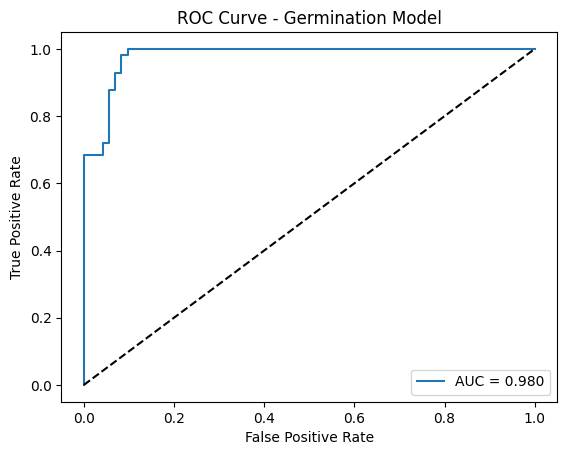

In [ ]:
# 📌 8. ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, y_prob):.3f}")
plt.plot([0,1],[0,1],"k--")
plt.title("ROC Curve - Germination Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [ ]:
# Save model
torch.save(model.state_dict(), MODEL_PATH)
print("Model saved to:", MODEL_PATH)


Model saved to: /content/drive/MyDrive/germination_project/germination_resnet18.pth


In [ ]:
# 📌 10. Inference Function (for dashboard integration)
infer_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

def predict_germination(img_path):
    img = Image.open(img_path).convert("RGB")
    x = infer_tf(img).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        prob = torch.sigmoid(model(x)).item()
    return prob